## Predicting Survival on the Titanic

### History
Perhaps one of the most infamous shipwrecks in history, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 people on board. Interestingly, by analysing the probability of survival based on few attributes like gender, age, and social status, we can make very accurate predictions on which passengers would survive. Some groups of people were more likely to survive than others, such as women, children, and the upper-class. Therefore, we can learn about the society priorities and privileges at the time.

### Assignment:

Build a Machine Learning Pipeline, to engineer the features in the data set and predict who is more likely to Survive the catastrophe.

Follow the Jupyter notebook below, and complete the missing bits of code, to achieve each one of the pipeline steps.

In [3]:
import re

# to handle datasets
import pandas as pd
import numpy as np
import ssl

# for visualization
import matplotlib.pyplot as plt

# to divide train and test set
from sklearn.model_selection import train_test_split

# feature scaling
from sklearn.preprocessing import StandardScaler

# to build the models
from sklearn.linear_model import LogisticRegression

# to evaluate the models
from sklearn.metrics import accuracy_score, roc_auc_score

# to persist the model and the scaler
import joblib

# to visualise al the columns in the dataframe
pd.pandas.set_option('display.max_columns', None)

## Prepare the data set

In [201]:
# load the data - it is available open source and online
ssl._create_default_https_context = ssl._create_unverified_context
data = pd.read_csv('https://www.openml.org/data/get_csv/16826755/phpMYEkMl')

# display data
data.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29,0,0,24160,211.3375,B5,S,2,?,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.55,C22 C26,S,11,?,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30,1,2,113781,151.55,C22 C26,S,?,135,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"


In [202]:
data.isnull().any().any()

False

In [203]:
# replace interrogation marks by NaN values

data = data.replace('?', np.nan)

In [204]:
# retain only the first cabin if more than
# 1 are available per passenger

def get_first_cabin(row):
    try:
        return row.split()[0]
    except:
        return np.nan
    
data['cabin'] = data['cabin'].apply(get_first_cabin)

In [205]:
# extracts the title (Mr, Ms, etc) from the name variable

def get_title(passenger):
    line = passenger
    if re.search('Mrs', line):
        return 'Mrs'
    elif re.search('Mr', line):
        return 'Mr'
    elif re.search('Miss', line):
        return 'Miss'
    elif re.search('Master', line):
        return 'Master'
    else:
        return 'Other'
    
data['title'] = data['name'].apply(get_title)

In [206]:
# cast numerical variables as floats

data['fare'] = data['fare'].astype('float')
data['age'] = data['age'].astype('float')

In [207]:
# drop unnecessary variables

data.drop(labels=['name','ticket', 'boat', 'body','home.dest'], axis=1, inplace=True)

# display data
data.head()

,pclass,survived,sex,age,sibsp,parch,fare,cabin,embarked,title
0,1,1,female,29.0000,0,0,211.3375,B5,S,Miss
1,1,1,male,0.9167,1,2,151.5500,C22,S,Master
2,1,0,female,2.0000,1,2,151.5500,C22,S,Miss
3,1,0,male,30.0000,1,2,151.5500,C22,S,Mr
4,1,0,female,25.0000,1,2,151.5500,C22,S,Mrs


In [208]:
# save the data set

data.to_csv('./datasets/titanic.csv', index=False)

## Data Exploration

### Find numerical and categorical variables

In [209]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   pclass    1309 non-null   int64  
 1   survived  1309 non-null   int64  
 2   sex       1309 non-null   object 
 3   age       1046 non-null   float64
 4   sibsp     1309 non-null   int64  
 5   parch     1309 non-null   int64  
 6   fare      1308 non-null   float64
 7   cabin     295 non-null    object 
 8   embarked  1307 non-null   object 
 9   title     1309 non-null   object 
dtypes: float64(2), int64(4), object(4)
memory usage: 102.4+ KB


In [210]:
target = 'survived'

In [211]:
vars_num = [var for var in data.columns if data[var].dtype != 'object']# fill your code here

vars_cat = [var for var in data.columns if data[var].dtype == 'object'] # fill your code here

print('Number of numerical variables: {}'.format(len(vars_num)))
print('Number of categorical variables: {}'.format(len(vars_cat)))

Number of numerical variables: 6
Number of categorical variables: 4


### Find missing values in variables

In [43]:
# first in numerical variables
vars_num_cont = ['age', 'fare']
vars_num_disc = [var for var in vars_num if var not in vars_num_cont]
vars_num_cont_w_na = [var for var in vars_num_cont if data[var].isnull().any()]
vars_num_disc_w_na = [var for var in vars_num_disc if data[var].isnull().any()]
print(vars_num_cont_w_na)
print(vars_num_disc_w_na)

['age', 'fare']
[]


In [44]:
# now in categorical variables
vars_cat_w_na = [var for var in vars_cat if data[var].isnull().any()]
print(vars_cat_w_na)

['cabin', 'embarked']


### Determine cardinality of categorical variables

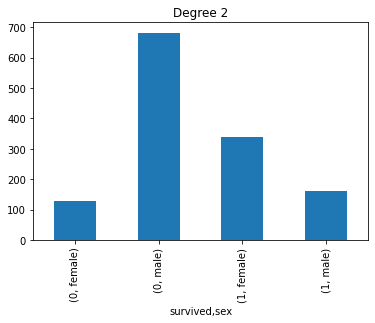

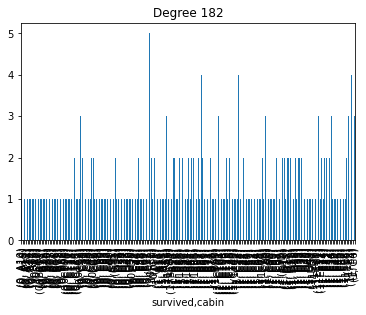

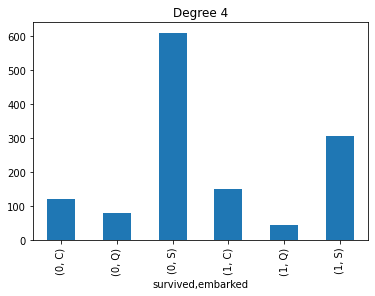

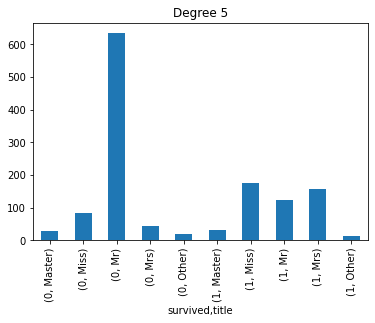

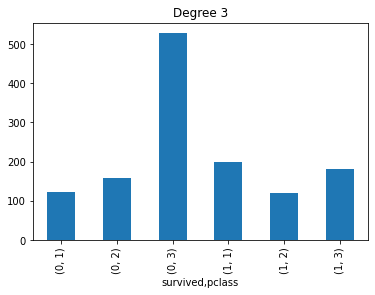

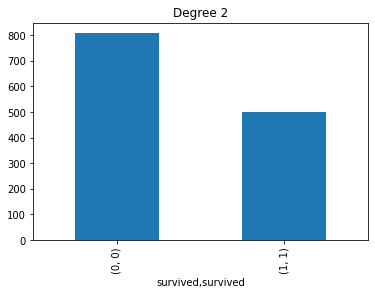

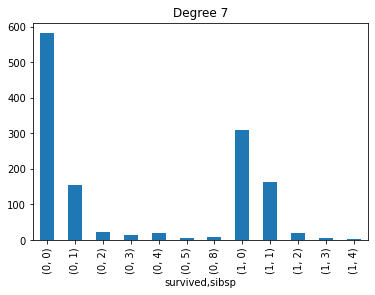

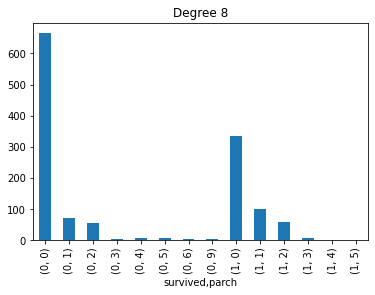

In [46]:
def analyze_cat_vars(orig_df, var):
    df = orig_df.copy()
    df.groupby(['survived', var])['survived'].count().plot.bar()
    plt.title(f'Degree {len(df[var].unique())}')
    plt.show()
    
for var in vars_cat + vars_num_disc:
    analyze_cat_vars(data, var)

### Determine the distribution of numerical variables

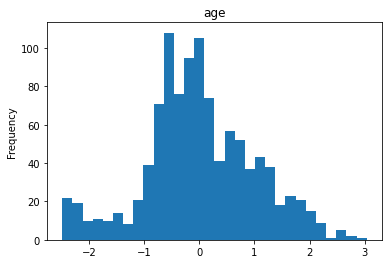

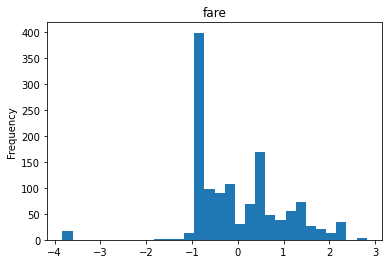

In [56]:
from sklearn.preprocessing import PowerTransformer

def analyze_vars_num(orig_df, var):
    tf = PowerTransformer()
    df = orig_df.copy()
    if not (df[var] < 0).any():
        df[var] = tf.fit_transform(np.array(df[var]).reshape(-1,1))
        df[var].plot.hist(bins=30)
    else:
        df[var].plot.hist(bins=30)
    plt.title(var)
    plt.show()
    
for var in vars_num_cont:
    analyze_vars_num(data, var)

## Separate data into train and test

Use the code below for reproducibility. Don't change it.

In [254]:
X_train, X_test, y_train, y_valid = train_test_split(
    data.drop('survived', axis=1),  # predictors
    data['survived'],  # target
    test_size=0.2,  # percentage of obs in test set
    random_state=42)  # seed to ensure reproducibility

X_train.shape, X_test.shape

((1047, 9), (262, 9))

## Feature Engineering

### Extract only the letter (and drop the number) from the variable Cabin

In [220]:
X_train_letter = X_train.copy()
X_valid_letter = X_test.copy()

X_train_letter['cabin'][X_train_letter['cabin'].notnull()] = X_train_letter['cabin'][X_train_letter['cabin'].notnull()].apply(lambda x: "".join(re.findall("[a-zA-Z]+", str(x))))
X_valid_letter['cabin'][X_valid_letter['cabin'].notnull()] = X_valid_letter['cabin'][X_valid_letter['cabin'].notnull()].apply(lambda x: "".join(re.findall("[a-zA-Z]+", str(x))))

/Users/boonchuay/Documents 2/deployment-of-ml-model/deploy-ml/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/boonchuay/Documents 2/deployment-of-ml-model/deploy-ml/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


### Fill in Missing data in numerical variables:

- Add a binary missing indicator
- Fill NA in original variable with the median

In [221]:
med_imputer = {}
X_train_filled = X_train_letter.copy()
X_valid_filled = X_valid_letter.copy()

for var in vars_num_cont_w_na:
    med_imputer[var] = X_train_filled[var].median()
    X_train_filled[var] = X_train_filled[var].fillna(med_imputer[var])
    X_valid_filled[var] = X_valid_filled[var].fillna(med_imputer[var])
    X_train_filled[var+'_na'] = np.where(X_train_filled[var].isnull(), 1, 0)
    X_valid_filled[var+'_na'] = np.where(X_valid_filled[var].isnull(), 1, 0)

### Replace Missing data in categorical variables with the string **Missing**

In [222]:
mode_imputer = {}

for var in vars_num_disc_w_na:
    if var != 'survived':
        mode_imputer[var] = X_train_filled[var].mode()
        X_train_filled[var] = X_train_filled[var].fillna(mode_imputer[var])
        X_valid_filled[var] = X_valid_filled[var].fillna(mode_imputer[var])
        X_train_filled[var+'_na'] = np.where(X_train_filled[var].isnull(), 1, 0)
        X_valid_filled[var+'_na'] = np.where(X_valid_filled[var].isnull(), 1, 0)

In [223]:
cat_imputer = {}

for var in vars_cat_w_na:
    cat_imputer[var] = 'Missing'
    X_train_filled[var] = X_train_filled[var].fillna(cat_imputer[var])
    X_valid_filled[var] = X_valid_filled[var].fillna(cat_imputer[var])
    X_train_filled[var+'_na'] = np.where(X_train_filled[var].isnull(), 1, 0)
    X_valid_filled[var+'_na'] = np.where(X_valid_filled[var].isnull(), 1, 0)

### Remove rare labels in categorical variables

- remove labels present in less than 5 % of the passengers

In [245]:
rare_labels = {}
X_train_rare = X_train_filled.copy()
X_valid_rare = X_valid_filled.copy()

def fit_transform_remove_rare_labels(orig_df, var, threshold = 0.05):
    df = orig_df.copy()
    rare_label = df.groupby(var)[var].count()[df.groupby(var)[var].count()/len(df) < threshold].index
    rare_labels[var] = rare_label
    df[var] = np.where(df[var].isin(rare_labels[var]), 'rare', df[var])
    return df

def transform_remove_rare_labels(orig_df, var, threshold = 0.05):
    df = orig_df.copy()
    df[var] = np.where(df[var].isin(rare_labels[var]), 'rare', df[var])
    return df

for var in vars_cat:
    if var != 'survived':
        X_train_rare = fit_transform_remove_rare_labels(X_train_rare, var)
        X_valid_rare = transform_remove_rare_labels(X_valid_rare, var)

### Perform one hot encoding of categorical variables into k-1 binary variables

- k-1, means that if the variable contains 9 different categories, we create 8 different binary variables
- Remember to drop the original categorical variable (the one with the strings) after the encoding

In [246]:
label_dics = {}
X_train_enc = X_train_rare.copy()
X_valid_enc = X_valid_rare.copy()

def fit_transform_label_encoding(orig_df, var):
    df = orig_df.copy()
    label = set(X_train_rare[var].unique()).union(X_valid_rare[var].unique())
    label_encoder = {k:i for i, k in enumerate(label)}
    label_dics[var] = label_encoder
    
    df[var] = df[var].map(lambda x: label_dics[var][x])
    return df

def transform_label_encoding(orig_df, var):
    df = orig_df.copy()
    df[var] = df[var].map(lambda x: label_dics[var][x])
    return df
    
for var in vars_cat:
    X_train_enc = fit_transform_label_encoding(X_train_enc, var)
    X_valid_enc = fit_transform_label_encoding(X_valid_enc, var)

In [244]:
X_train_enc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1047 entries, 772 to 1126
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   pclass       1047 non-null   int64  
 1   sex          1047 non-null   int64  
 2   age          1047 non-null   float64
 3   sibsp        1047 non-null   int64  
 4   parch        1047 non-null   int64  
 5   fare         1047 non-null   float64
 6   cabin        1047 non-null   int64  
 7   embarked     1047 non-null   int64  
 8   title        1047 non-null   int64  
 9   age_na       1047 non-null   int64  
 10  fare_na      1047 non-null   int64  
 11  cabin_na     1047 non-null   int64  
 12  embarked_na  1047 non-null   int64  
dtypes: float64(2), int64(11)
memory usage: 154.5 KB


### Scale the variables

- Use the standard scaler from Scikit-learn

In [250]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train_enc)

train_features = X_train_enc.columns

X_train_prep = X_train_enc.copy()
X_valid_prep = X_valid_enc.copy()

X_train_prep[train_features] = scaler.transform(X_train_enc)
X_valid_prep[train_features] = scaler.transform(X_valid_enc)

In [252]:
X_train_prep.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1047 entries, 772 to 1126
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   pclass       1047 non-null   float64
 1   sex          1047 non-null   float64
 2   age          1047 non-null   float64
 3   sibsp        1047 non-null   float64
 4   parch        1047 non-null   float64
 5   fare         1047 non-null   float64
 6   cabin        1047 non-null   float64
 7   embarked     1047 non-null   float64
 8   title        1047 non-null   float64
 9   age_na       1047 non-null   float64
 10  fare_na      1047 non-null   float64
 11  cabin_na     1047 non-null   float64
 12  embarked_na  1047 non-null   float64
dtypes: float64(13)
memory usage: 154.5 KB


## Train the Logistic Regression model

- Set the regularization parameter to 0.0005
- Set the seed to 0

In [280]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

np.random.seed(42)
params_grid = {'C': uniform(0.0001, 10)}
estimator = LogisticRegression()

est_cv = RandomizedSearchCV(estimator, params_grid, n_iter=50)
est_cv.fit(X_train_prep, y_train)
est_cv.best_estimator_.score(X_train_prep, y_train)

0.7965616045845272

## Make predictions and evaluate model performance

Determine:
- roc-auc
- accuracy

**Important, remember that to determine the accuracy, you need the outcome 0, 1, referring to survived or not. But to determine the roc-auc you need the probability of survival.**

0.7862595419847328
0.8549905838041432


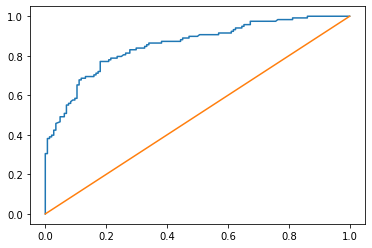

In [284]:
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score

print(accuracy_score(y_valid, est_cv.best_estimator_.predict(X_valid_prep)))
fpr, tpr, threshold = roc_curve(y_valid, est_cv.best_estimator_.predict_proba(X_valid_prep)[:, 1])
print(roc_auc_score(y_valid, est_cv.best_estimator_.predict_proba(X_valid_prep)[:, 1]))

plt.plot(fpr, tpr)
plt.plot([0,1],[0,1])

That's it! Well done

**Keep this code safe, as we will use this notebook later on, to build production code, in our next assignement!!**

In [285]:
joblib.dump(est_cv, './datasets/logistic_regression_1')

['./datasets/logistic_regression_1']

## Train random forest

In [304]:
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint

np.random.seed(42)
params_grid = {'n_estimators': randint(2,15), 'max_depth': randint(2,15), 'max_leaf_nodes':randint(2,15)}
rs = RandomForestClassifier()

rs_cv = RandomizedSearchCV(rs, params_grid, n_iter=50, cv=6)
rs_cv.fit(X_train_prep, y_train)

RandomizedSearchCV(cv=6, estimator=RandomForestClassifier(), n_iter=50,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ff9e9de7910>,
                                        'max_leaf_nodes': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ff9e9de7e50>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ff9e9de7850>})

In [305]:
rs_cv.best_estimator_

RandomForestClassifier(max_depth=10, max_leaf_nodes=14, n_estimators=14)

In [306]:
rs_cv.best_estimator_.score(X_train_prep, y_train)

0.8347659980897804

0.7748091603053435
0.845721516007533


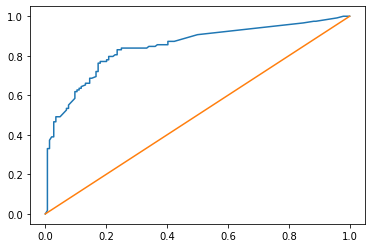

In [307]:
print(accuracy_score(y_valid, rs_cv.best_estimator_.predict(X_valid_prep)))
fpr, tpr, threshold = roc_curve(y_valid, rs_cv.best_estimator_.predict_proba(X_valid_prep)[:, 1])
print(roc_auc_score(y_valid, rs_cv.best_estimator_.predict_proba(X_valid_prep)[:, 1]))

plt.plot(fpr, tpr)
plt.plot([0,1],[0,1])

## Make a test and submit